In [16]:
import numpy as np
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('seaborn-notebook')
%matplotlib inline

In [695]:
z = loadmat('wave_shaped.mat')
X_train, y_train, X_test, y_test = z['X_train'], z['T_train'].flatten(), z['X_test'], z['T_test'].flatten()

In [696]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def visualize(X, y):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    y = y.flatten()
    # Triangulate parameter space to determine the triangles
    #tri = Delaunay(X)
    ax.plot_trisurf(X[:,0], X[:,1], y, cmap=plt.cm.Spectral, lw=0)
    ax.set(xlabel="$X_1$", ylabel="$X_2$", zlabel="$y$")

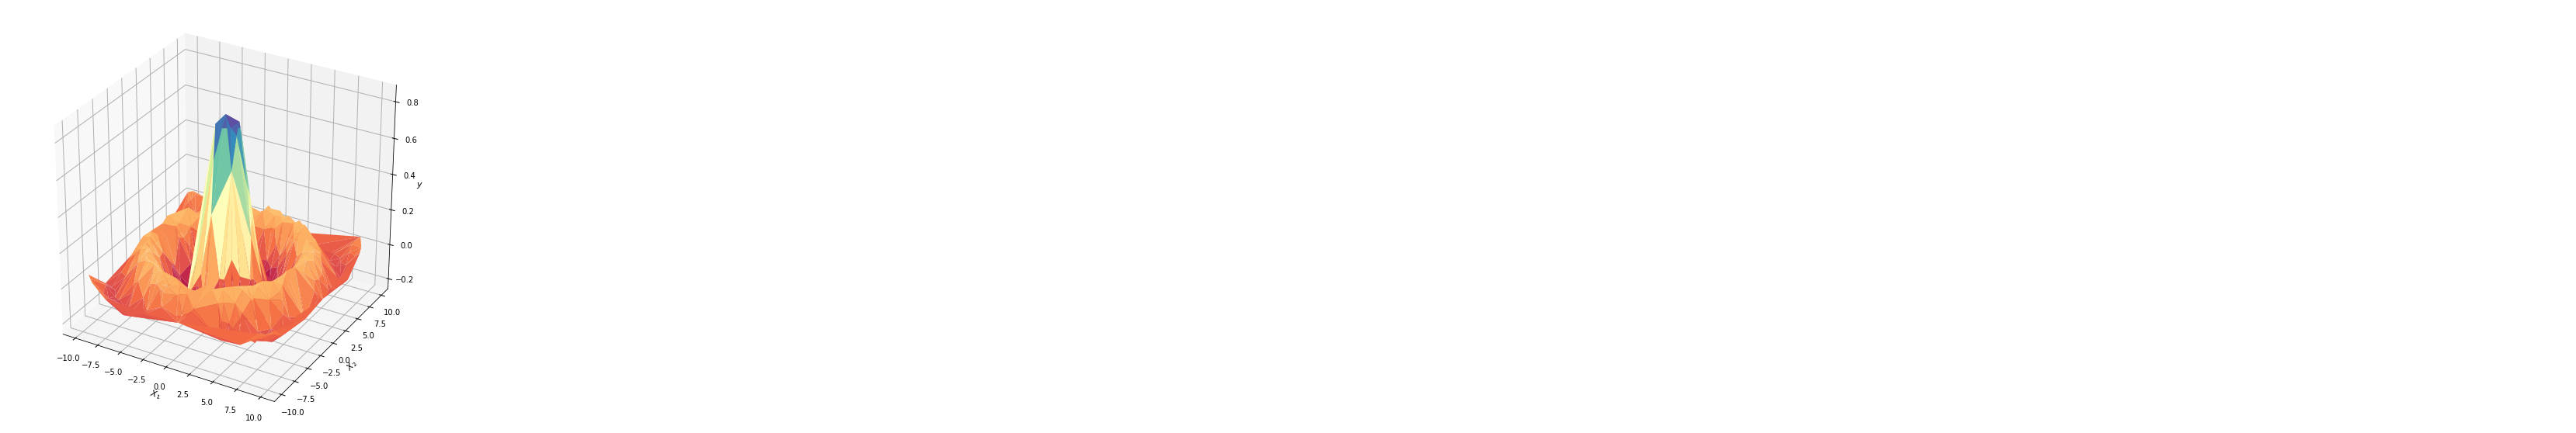

In [697]:
visualize(X_train, y_train)

# Basis functions: the frequentist way

In [700]:
from sklearn.cluster import KMeans

def distance(x, p):
    return np.mean(np.linalg.norm(x-p))

def rbfn(X, y, nb_centroids, smoothing=0.1):
    # Find centroids
    kmeans = KMeans(n_clusters=nb_centroids, random_state=0)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_

    # Find widths
    widths = [smoothing * distance(X_train[labels==i], centroids[i]) for i in range(kmeans.n_clusters)]
    
    # Find weights
    def ϕ(x_i, j):
        σ_j = widths[j]
        c_j = centroids[j]
        return np.exp(- np.linalg.norm(x_i - c_j)**2 / (2 * σ_j**2))
    
    Φ = np.asarray([[ϕ(X[i,:],j) for j in range(nb_centroids)] for i in range(X.shape[0])])
    Φ = np.c_[np.ones(X.shape[0]), Φ]  # add intercept
    weights = (np.linalg.pinv(Φ.T @ Φ) @ Φ.T @ y).flatten()
    
    return lambda x: weights[0] + np.sum([weights[j+1] * ϕ(x, j) for j in range(nb_centroids)])

In [715]:
def mse(z1, z2):
    return np.mean((z1 - z2)**2)

### Validation with 8 centroids

MSE: 0.022617097799348663


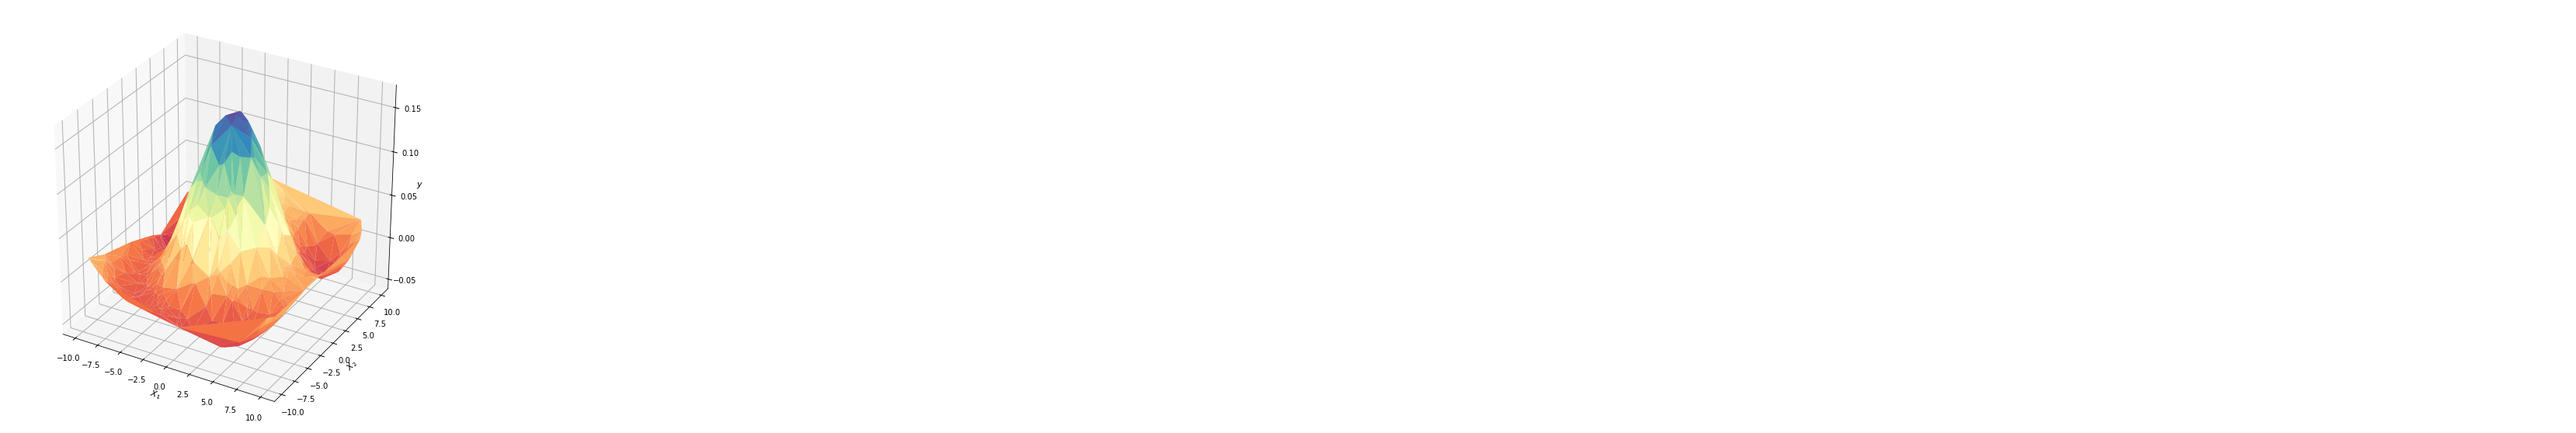

In [738]:
# Training
fitted_function = rbfn(X_train, y_train, 8, smoothing=.2)
# Testing
y_hat = np.apply_along_axis(fitted_function, 1, X_train)
print("MSE:", mse(y_hat, y_train))
visualize(X_train, y_hat)

### Validation with 50 centroids

MSE: 0.0012724323796555698


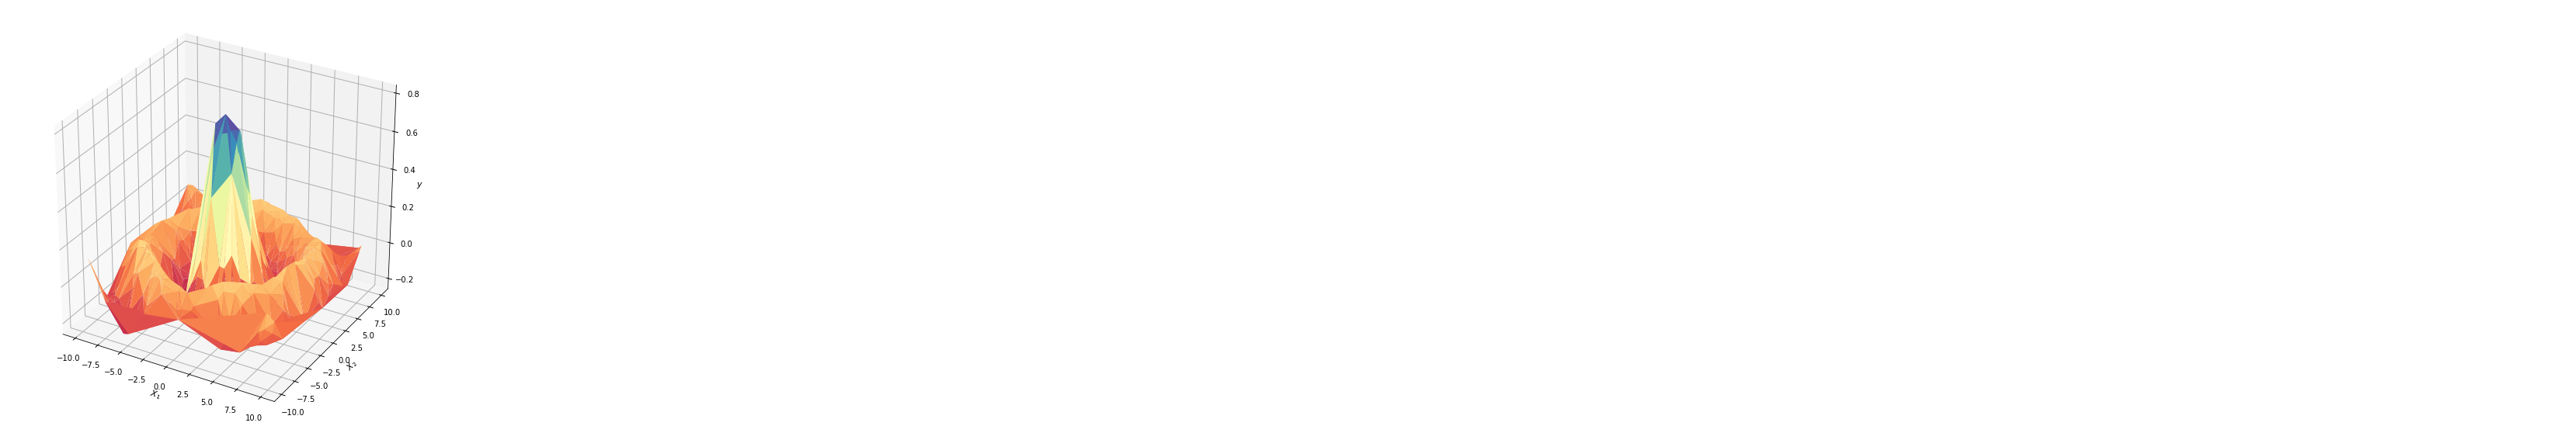

In [739]:
# Training
fitted_function = rbfn(X_train, y_train, 50, smoothing=1)
# Testing
y_hat = np.apply_along_axis(fitted_function, 1, X_train)
print("MSE:", mse(y_hat, y_train))
visualize(X_train, y_hat)

### Overfitting and underfitting

In [740]:
def mse_from_model(nb_centroids, smoothing):
    fitted_function = rbfn(X_train, y_train, nb_centroids=nb_centroids, smoothing=smoothing)
    y_hat = np.apply_along_axis(fitted_function, 1, X_test)
    return mse(y_hat, y_test)

In [743]:
nb_centroids_range = np.arange(1, 40, 1)
mse_range = [mse_from_model(nb_centroids, 1) for nb_centroids in nb_centroids_range]

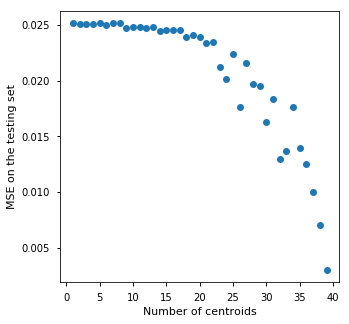

In [744]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(nb_centroids_range, mse_range, 'o')
ax.set(xlabel='Number of centroids', ylabel='MSE on the testing set');

# [Not in the exercices] Using Gaussian processes, the Bayesian way

In [708]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# We add a white kernel to model the noise
kernel = RBF(10) + WhiteKernel(.01)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=10) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=0)

In [709]:
gpr.score(X_train, y_train), gpr.score(X_test, y_test)

(0.9967217561876094, 0.9952770778428521)

In [721]:
y_hat = gpr.predict(X_train).flatten()
mse(y_train, y_hat)

8.202717693437341e-05

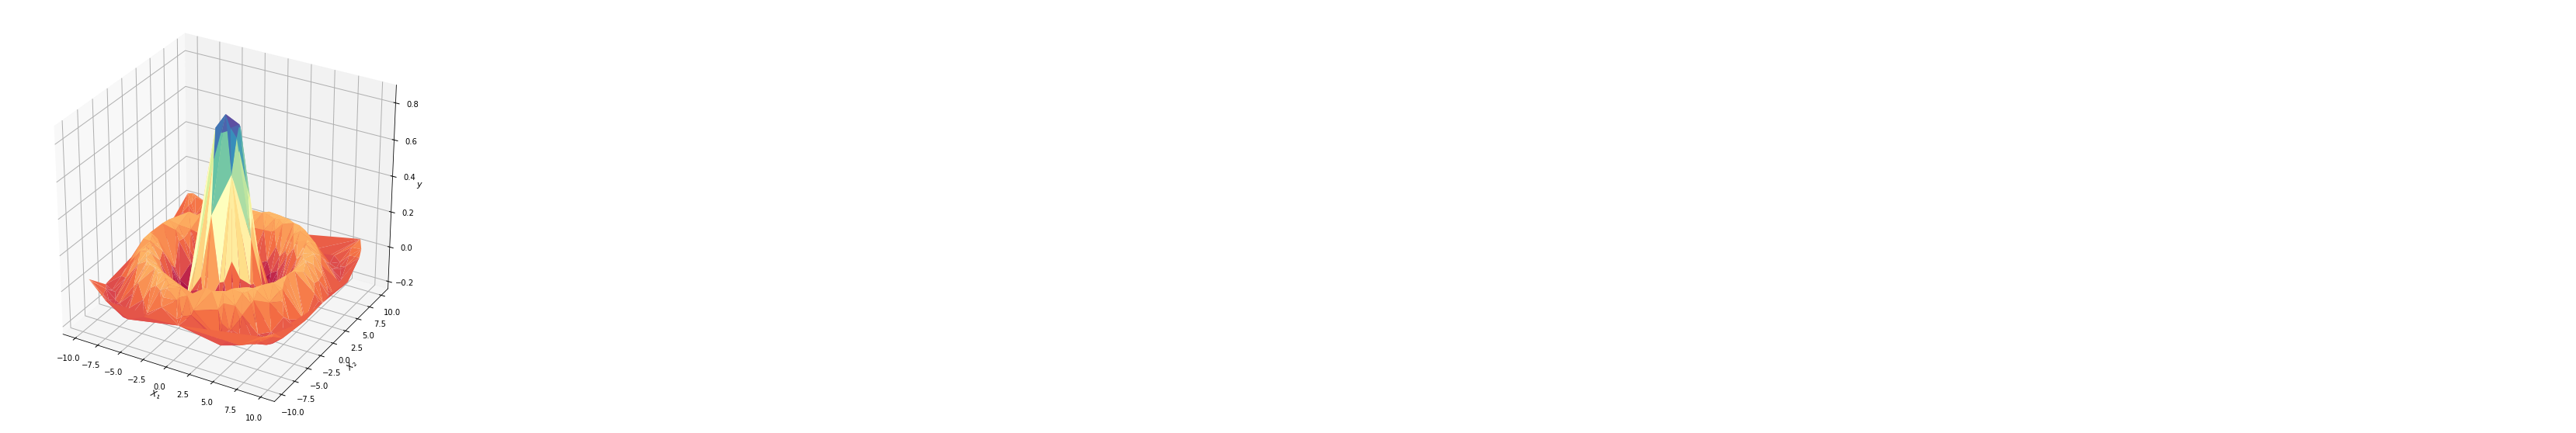

In [723]:
visualize(X_train, y_hat)

In [724]:
y_hat = gpr.predict(X_test).flatten()
mse(y_test, y_hat)

0.00012621842105163284

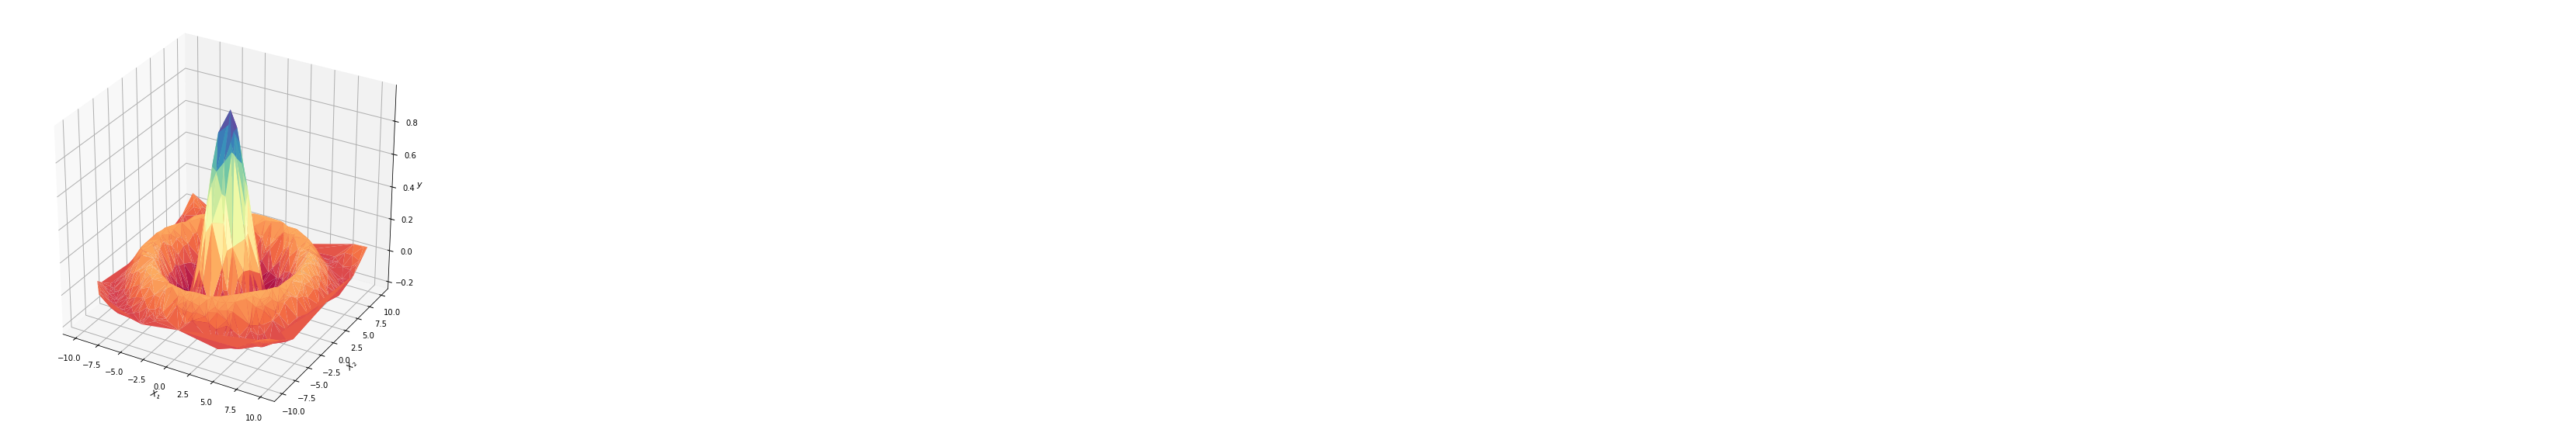

In [725]:
visualize(X_test, y_hat)